## Behavioral cloning Project


In [106]:
import os
def  extractFileName ( ssd_folder, abs_path):

    if os.name == "nt":
        split_char = '\\' 
    else:
        split_char = '/' 
        
    if '\\' in abs_path:
        # "  Windows Path " 
#         print ("windows path ")
        image_name = ssd_folder\
                    +split_char + abs_path.split ('\\')[-2] \
                    + split_char +abs_path.split ('\\')[-1]
#         print (image_name)

    else:
        # "  Unix Path " 
        image_name = ssd_folder \
                     + split_char + abs_path.split ('/')[-2] \
                     + split_char + abs_path.split ('/')[-1]
#         print ( "image_name = " + image_name)
    
    return image_name

### Copy data folder to ssd

In [107]:
ssd_folder = "/ssd_data/project3"

In [108]:
# import shutil 

# shutil.rmtree(ssd_folder)
# print ( "Copying files to ssd ....")
# shutil.copytree ("data",ssd_folder)
# print ( "... completed")



### Defining the Sample Pytable

In [109]:
hdf5_training.close()
hdf5_validation.close()


In [110]:
from  tables import *
import tables

hdf5_training = open_file(ssd_folder + "/training_samples.hdf5", mode = "w", title = "Training Samples")
hdf5_validation = open_file(ssd_folder + "/validation_samples.hdf5", mode = "w", title = "Validation Samples")


#### Defining the resize shape of the images ( this parameter will be used also in the Generator and in the Model definition)

In [111]:
resized_shape = 128

## Defining the batch size:
batch_size = 128

### Defining the Queue loader chunk size  
queue_loader_chunk = 400 # batch_size(128) * 400 , = 51200 images


### Defining the two objects as images container:


In [112]:
py_training_samples   = hdf5_training.create_earray(hdf5_training.root, \
                    'training_images', \
                    tables.UInt8Atom(), \
                    shape=( 0,resized_shape, resized_shape, 3),chunkshape=(batch_size*queue_loader_chunk ,32,32,3))

py_validation_samples = hdf5_validation.create_earray(hdf5_validation.root, \
                     'validation_images', tables.UInt8Atom(), \
                     shape=( 0,resized_shape, resized_shape, 3),chunkshape=(batch_size*queue_loader_chunk,32,32,3))



In [113]:
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting .... ")
samples_list = []
center_image_before = None
for name in glob.glob(ssd_folder + "/*.csv"):
    print ( "Reading from logfile = " + name)
    with open(name)  as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                samples_list.append([extractFileName(ssd_folder, line[0]),\
                                     extractFileName(ssd_folder, line[1]),\
                                     extractFileName(ssd_folder, line[2]),\
                                     float(line[3])])
                
print ("\n\nThere are {} samples in total ".format(len(samples_list)))



Starting .... 
Reading from logfile = /ssd_data/project3/run5.csv
Reading from logfile = /ssd_data/project3/run3.csv
Reading from logfile = /ssd_data/project3/run4.csv
Reading from logfile = /ssd_data/project3/track1_run1.csv
Reading from logfile = /ssd_data/project3/run2.csv
Reading from logfile = /ssd_data/project3/run1.csv


There are 15909 samples in total 


In [114]:
np.array(samples_list).shape

(15909, 4)

### Adding recurrent data

#### Adding previous images with the CURRENT steering angle



In [115]:
print ("Creating recurrent data")
samples_list_recurrent = []
for i,line in enumerate(samples_list):
  if i% 1000 == 0 and i> 0 : print(".. recurrent data processed {}".format(i))     
  for ix in range( max(i-1,0), max(i-5,0), -1):  
      current_steering_angle = line[3]
        
      samples_list_recurrent.append([samples_list[ix][0] ,samples_list[ix][1] ,samples_list[ix][2] ,line[3]]) 
#       samples_list_recurrent.append([1,1,1,.1])

print ("\nNew recurrent samples created {}".format(len(samples_list_recurrent)))


Creating recurrent data
.. recurrent data processed 1000
.. recurrent data processed 2000
.. recurrent data processed 3000
.. recurrent data processed 4000
.. recurrent data processed 5000
.. recurrent data processed 6000
.. recurrent data processed 7000
.. recurrent data processed 8000
.. recurrent data processed 9000
.. recurrent data processed 10000
.. recurrent data processed 11000
.. recurrent data processed 12000
.. recurrent data processed 13000
.. recurrent data processed 14000
.. recurrent data processed 15000

New recurrent samples created 63622


### Appending recurrent data to sample list

In [116]:
# samples_list = samples_list + samples_list_recurrent
# print ("\nTotal samples including recurrent {}".format(len(samples_list)))


### Splitting into Training and Validation

In [117]:
from random import shuffle
shuffle(samples_list)

train_list = samples_list[0:int(0.6666*len(samples_list))]

val_list = samples_list[int(0.6666*len(samples_list)):int(1.0*len(samples_list))]


print ("\n\nThere are {} images in total ".format(len(samples_list)))
print ("....splitted into training images = {}  ".format(len(train_list)))
print ("                  val images      = {}  ".format(len(val_list)))
print ("                  total           = {}  ".format(len(train_list)+len(val_list)))





There are 15909 images in total 
....splitted into training images = 10604  
                  val images      = 5305  
                  total           = 15909  


In [118]:
def data_preprocess(line):
        preprocessed_samples=[]
        # STEERING ANGLE CALCULATION
        correction = 0.03 # this is a parameter to tune
        center_steering = float(line[3])
        left_steering   = center_steering + correction
        right_steering  = center_steering - correction

        # CENTER IMAGE
        center_image = cv2.imread(extractFileName( ssd_folder, line[0]))
#         print (extractFileName(ssd_folder,  line[0]))
        center_image = cv2.cvtColor (center_image, cv2.COLOR_BGR2RGB)
        center_image = cv2.resize(center_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([center_image, center_steering ])

        #   LEFT IMAGE
        left_image = cv2.imread(extractFileName(ssd_folder,  line[1]))
        left_image = cv2.cvtColor (left_image, cv2.COLOR_BGR2RGB)
        left_image = cv2.resize(left_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([left_image, left_steering ])

        #   RIGHT IMAGE
        right_image = cv2.imread(extractFileName(ssd_folder,  line[2]))
        right_image = cv2.cvtColor (right_image, cv2.COLOR_BGR2RGB)
        right_image = cv2.resize(right_image,(resized_shape,resized_shape ))
        preprocessed_samples.append([right_image, right_steering ])


#         ###
#         ### IMAGE AUGMENTATION
#         ###
#         # augmented center image
#         preprocessed_samples.append([cv2.flip(center_image,1), center_steering*-1.0 ])

#         # augmented left image
#         preprocessed_samples.append([cv2.flip(left_image  ,1), left_steering  *-1.0] )

#         # augmented right image
#         preprocessed_samples.append([cv2.flip(right_image,1),  right_steering *-1.0] )
        
#         print ( "here 1 {}".format( np.array(preprocessed_samples).shape))
        return np.array(preprocessed_samples)

### Image preprocessing using the function defined before

In [119]:
    
import os
import csv
import cv2
import numpy as np
import glob

print ( "Starting Images Preprocessing  .... ")
train_samples      =  np.array([]).reshape(0,2)
validation_samples =  np.array([]).reshape(0,2)
training_steering = []
val_steering = []

### Training samples
for i,sample_line in enumerate(train_list):
   for output in data_preprocess(sample_line):
        py_training_samples.append(output[0][None])
        training_steering.append(output[1])
            
   if i% 5000 == 0 and i> 0 : print(".. training samples processed {}".format(i))     

### Validation samples   
for i,sample_line in enumerate(val_list):
   for output in data_preprocess(sample_line):
        py_validation_samples.append(output[0][None])
        val_steering.append(output[1])

   if i% 1000 == 0 and i> 0 : print(".. validation samples processed {}".format(i))     


print ("\nTotal training samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(py_training_samples)) ))
print ("\nTotal validation samples {}x{} after augmentation and preprocessing : {} "\
       .format(resized_shape,resized_shape,\
        str(len(py_validation_samples)) ))
print ( "... completed")


Starting Images Preprocessing  .... 
.. training samples processed 5000
.. training samples processed 10000
.. validation samples processed 1000
.. validation samples processed 2000
.. validation samples processed 3000
.. validation samples processed 4000
.. validation samples processed 5000

Total training samples 128x128 after augmentation and preprocessing : 31812 

Total validation samples 128x128 after augmentation and preprocessing : 15915 
... completed


### Defining the table arrays and copying the labels data inside


In [120]:
py_training_steerings = hdf5_training.create_array(hdf5_training.root, 'training_steerings',training_steering )
py_validation_steerings = hdf5_validation.create_array(hdf5_validation.root, 'validation_steerings', val_steering)

## EXPLORING THE DATA


Exploring the dataset ...


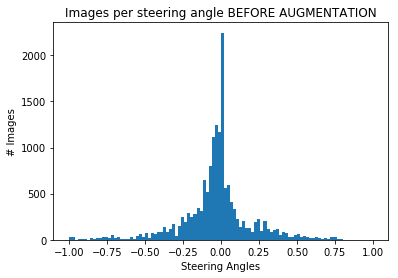

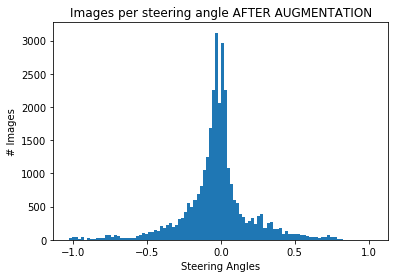

Exploring the dataset complete.


In [121]:
import matplotlib.pyplot as plt
 
print("\nExploring the dataset ...")
 
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()
 
# # It plots the histogram of an arrray of associative arrays of angles: [{'steering':0.1}, {'steering':0.2}, ..., {'steering':-0.1}]
def plot_dataset_histogram(samples, title, num_bins=100):
    steerings = []
    for item in samples:
#         print (item)
        steerings.append( float(item) )
    plot_steering_histogram(steerings, title, num_bins)

samples_before = np.array(samples_list)[:,3]
# Plot the histogram of steering angles before the image augmentation
plot_dataset_histogram(samples_before, 'Images per steering angle BEFORE AUGMENTATION', num_bins=100)
samples_before = []

# Plot the histogram of steering angles after the image augmentation
plot_dataset_histogram(training_steering, 'Images per steering angle AFTER AUGMENTATION', num_bins=100)
print("Exploring the dataset complete.")
samples=[]




## Model definition using Keras

#### NVIDIA model used
#### Image normalization to avoid saturation and make gradients work better.
####     Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
####     Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
####     Drop out (0.5)
####     Fully connected: neurons: 100, activation: ELU
####     Fully connected: neurons: 50, activation: ELU
####     Fully connected: neurons: 10, activation: ELU
####     Fully connected: neurons: 1 (output)

In [122]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Activation, Dropout, Reshape, LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
top_crop = int(resized_shape*10/100)
bottom_crop = int(resized_shape*34/100)
print ( "top_crop =" + str(top_crop))
print ( "bottom_crop =" + str(bottom_crop))

# Data Preprocessing ( Normalization and mean centering)
model.add(Cropping2D(cropping =((bottom_crop,top_crop),(0,0)), input_shape = (resized_shape,resized_shape,3), name ="cropping") )
model.add(Lambda(lambda x: x/127.5 - 1. , input_shape = (resized_shape,resized_shape,3)))
# model.add(Dropout(0.5))

model.add(Conv2D(24, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv1"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
# model.add(Dropout(0.5))

model.add(Conv2D(36, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv2"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
# model.add(Dropout(0.5))

model.add(Conv2D(48, (5, 5), activation='elu', padding='valid',strides=(2, 2), name = "Conv3"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv4"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

# model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='elu', padding='valid',strides=(1, 1), name = "Conv5"))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(100, activation='elu'))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation
model.add(Dropout(0.5))

model.add(Dense(50, activation='elu'))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dense(10, activation='elu'))
# model.add(LeakyReLU(alpha=.001))   # add an advanced activation

model.add(Dense(1,kernel_initializer='random_uniform',bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')

print (model.summary())

top_crop =12
bottom_crop =43
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping (Cropping2D)        (None, 73, 128, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 73, 128, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 35, 62, 24)        1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 16, 29, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 6, 13, 48)         43248     
_________________________________________________________________
Conv4 (Conv2D)               (None, 4, 11, 64)         27712     
_________________________________________________________________
Conv5 (Conv2D)               (None, 2, 9, 64)  

## Defining the generators .
### This flushes the files content from disk and return it to Tensorflow for the training fit
### The generator is repeated many times ( as many Epochs of training )



### Defining the Queue Thread process
#### Here I am creating a function that will be called in a separate thread . This simply read big Chunks from Disk ( also the Pytable ) , shuffle them, and make them at disposition of a further processer in a Python Queue.
#### The size of this two Queue , samples_q and labels_q is defined as batch_size * queue_chunk

#### The great thing about Python Queue is that , if we define the maxsize, the put instruction in case the Queue is full, will wait until will be some space free. 
#### **** This is useful to AVOID TO LOAD THE ENTIRE PYTABLE IN MEMORY ****

In [123]:
import sklearn
from time import sleep 

from sklearn.utils import shuffle

def read_images_into_queue(samples_q, labels_q , samples, labels):
#     print ( " reading images into Queue")
    # Define the Queue max size , the Queue.put() automatically do wait until records will be get from 
    # an other process and will free some space in the queue.
#     From docs.python.org:
#     The Queue module implements multi-producer, multi-consumer queues. 
#     It is especially useful in threaded programming when information must be exchanged safely between multiple threads. 
#     The Queue class in this module implements all the required locking semantics. 
#     It depends on the availability of thread support in Python; see the threading module.

    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 200))
    plt.subplot(100, 4, 1 )
    plt.axis('off')

    numsamples = len(samples)
#     print (" Samples shape " + str(samples.shape))
#     print (" Numsamples = " + str(numsamples))
    step = batch_size*queue_loader_chunk

    i = 0
    while 1:  ### remember you need to stop the process !!
#         print ("numsamples = " + str(numsamples))
        for offset in range(0, numsamples, step):
            # loading into memory a BIG chunk of data ( 32* queue_loader_chunk  )
            chunk_batch_samples = samples[offset:offset+step]
            chunk_batch_labels  = labels[offset:offset+step]
            
            # SHUFFLE !! REALLY IMPORTANT !!
            chunk_batch_samples, chunk_batch_labels = shuffle(chunk_batch_samples, chunk_batch_labels )
            for sample, steering in zip ( chunk_batch_samples,chunk_batch_labels):
                samples_q.put(sample)
                labels_q.put(steering)
#                 sleep (0.1)
            plt.show()  
    

#### Starting the reading processes -- from Disk to Memory Queue
#### Remember to TERMINATE them !!

In [126]:
training_producer.terminate()
validation_producer.terminate()


NameError: name 'training_producer' is not defined

In [74]:
# for steering in py_training_steerings_part1:
#     print ( "steering = " + str(steering ))

In [127]:
from multiprocessing import Process, Queue

training_samples_q = Queue(maxsize = 70)
# training_samples_q = Queue(maxsize = batch_size * queue_loader_chunk)

# training_labels_q = Queue(maxsize = batch_size * queue_loader_chunk)
training_labels_q = Queue(maxsize = 70)

validation_samples_q = Queue(maxsize = batch_size * queue_loader_chunk)
validation_labels_q = Queue(maxsize = batch_size * queue_loader_chunk)

###############################################################
# Training Producers . They load training data into Queues
# ###############################################################
training_producer = Process(target=read_images_into_queue, 
                            args=(training_samples_q,            # <-- Training images queue
                                  training_labels_q,             # <-- Training labels queue
                                  py_training_samples,           # <-- Training samples Pytable
                                  py_training_steerings))        # <-- Training labels  Pytable
training_producer.start()



###############################################################
# Validation Producers. They load validation data into Queues
###############################################################
validation_producer = Process(target=read_images_into_queue, 
                            args=(validation_samples_q,              # <-- Training images queue
                                  validation_labels_q,               # <-- Training labels queue
                                  py_validation_samples,           # <-- Training samples Pytable
                                  py_validation_steerings))        # <-- Training labels  Pytable
validation_producer.start()



## training_producer1.terminate()
## training_producer2.terminate()

## validation_producer1.terminate()
## validation_producer2.terminate()



#### Defining the generator

In [128]:
#### Defining thread safe generator
import cv2
import numpy as np
import sklearn
import threading

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def generator(samples_q, labels_q, batch_size ):
    %matplotlib inline
    import matplotlib.pyplot as plt
#     plt.figure(figsize=(20, 200))
# #     plt.subplot(50, 4, 1 )
#     plt.axis('off')
#     for i, image in enumerate(py_training_samples_part1):
#            plt.subplot(50, 4, i+2 )
#            plt.axis('off')
#            plt.imshow(image, cmap='gray')
#     plt.show()  
    read_nb = 0
    while 1: # Loop forever so the generator never terminates
        
        images = []
        angles=[]
        for i in range(0, batch_size):
            image = samples_q.get()
            steering = labels_q.get()
#             plt.imshow(image)
#             plt.title(steering)
#             plt.show()
            images.append(image)
            angles.append(steering)

        yield np.array(images) , np.array(angles)


#### Creating the Train and Validation generators:

In [129]:
## Note that the traing_generator uses Queue and async thread !
train_generator      = generator(training_samples_q, 
                                 training_labels_q, 
                                 batch_size)

validation_generator = generator(validation_samples_q, 
                                 validation_labels_q, 
                                 batch_size)

#### Training the model using traing_generator and validating with validation_generator

Epoch 1/30
249/248 [==============================] - 16s - loss: 0.0253 - val_loss: 0.0183
Epoch 2/30
249/248 [==============================] - 13s - loss: 0.0186 - val_loss: 0.0160
Epoch 3/30
249/248 [==============================] - 13s - loss: 0.0161 - val_loss: 0.0155
Epoch 4/30
249/248 [==============================] - 13s - loss: 0.0147 - val_loss: 0.0134
Epoch 5/30
249/248 [==============================] - 13s - loss: 0.0138 - val_loss: 0.0133
Epoch 6/30
249/248 [==============================] - 13s - loss: 0.0123 - val_loss: 0.0132
Epoch 7/30
249/248 [==============================] - 13s - loss: 0.0114 - val_loss: 0.0119
Epoch 8/30
249/248 [==============================] - 13s - loss: 0.0108 - val_loss: 0.0121
Epoch 9/30
249/248 [==============================] - 13s - loss: 0.0103 - val_loss: 0.0100
Epoch 10/30
249/248 [==============================] - 13s - loss: 0.0094 - val_loss: 0.0098
Epoch 11/30
249/248 [==============================] - 13s - loss: 0.0088 - val

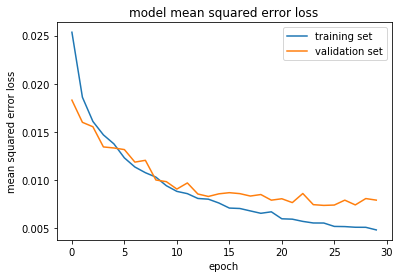

NameError: name 'validation_producer2' is not defined

In [130]:
epochs = 30

from datetime import datetime
start_time = datetime.now()

model.compile(loss='mse', optimizer='adam')

numper_of_train_samples      = len(py_training_samples)
number_of_validation_samples = len(py_validation_samples) 

history_object = model.fit_generator(train_generator, steps_per_epoch= \
                                     numper_of_train_samples/batch_size, 
                                     validation_data=validation_generator, \
                                     validation_steps=number_of_validation_samples/batch_size, 
                                     epochs=epochs, verbose = 1,\
                                     workers=4)

end_time = datetime.now()
print('\nTotal number of train samples: {} ( shape {}x{})'.format(numper_of_train_samples,resized_shape,resized_shape))
print('\nBatch Size                   : {}'.format(batch_size))
print('\nDuration                     : {}'.format(end_time - start_time))

from keras.models import save_model

save_model(model, "model.h5")
print ( "  ")
print ( " .. model saved to model.h5 ")
print ( "  ")


### print the keys contained in the history object
# print(history_object.history.keys())

import matplotlib.pyplot as plt
# # # Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

training_producer1.terminate()
training_producer2.terminate()

validation_producer1.terminate()
validation_producer2.terminate()


In [1]:
training_producer1.terminate()
training_producer2.terminate()

validation_producer1.terminate()
validation_producer2.terminate()

NameError: name 'training_producer1' is not defined

#### Image Convolution broken down in small pieces 

### Here I am trying to visualize the Convolution Layers to understand visually how many filters I should use

In [ ]:
# print (" Loading drive.h5 .......")

# from keras.models import load_model
# from keras.models import Model

# modelobj = load_model('drive.h5')
# print (" ..... model drive.h5 successfully loaded")


#### For this purpose I am loading a Test image from disk

In [ ]:
plt.imshow(py_training_samples_part1[3000], cmap='gray')

plt.show()

In [ ]:
# # Load test images
# import cv2
# import numpy as np
# test_images = []

# image = cv2.imread('./test_images/center1.jpg')
# image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image,(resized_shape,resized_shape ))     
# test_images.append(image)


# test_images = np.array(test_images)


#### First of all I am looking at the Image Crop if is well done in the right position:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'cropping'
# intermediate_layer_model = Model(inputs=modelobj.input,
#                                  outputs=modelobj.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# intermediate_output.shape


In [ ]:
# # Show the cropped images
# def show_intermediate_output(image_ori, intermediate_output):
#     print (intermediate_output.shape)
#     depth = 0 
#     %matplotlib inline
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(20, 100))
#     new_image = []
#     plt.subplot(40, 5, 1 )
#     plt.axis('off')
#     plt.imshow(image_ori)
#     for i in range(0,intermediate_output[0,0].shape[0]):
#            single_output = intermediate_output[:,:,i]
# #            print ( "single_output.shape {}".format(single_output.shape ))
# #            print ( single_output)
#            plt.subplot(40, 5, i+2 )
#            plt.axis('off')
#            single_output = single_output.astype(np.uint8)
#            plt.imshow(single_output, cmap='gray')
#     plt.show()    

    
# show_intermediate_output(test_images[0], intermediate_output[0])

#### Now the FIRST convolutional layer:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv1'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

#### Now the SECOND convolutional layer:

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv2'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 3

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv3'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Conv 4

In [ ]:
# # Call the model to calculate an intermediate layer using the test images
# layer_name = 'Conv4'
# intermediate_layer_model = Model(input=model.input,
#                                  output=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(test_images)
# int_unNorm = (intermediate_output[0]+1) * 127.5
# show_intermediate_output(test_images[0], int_unNorm ) 
                            
            

### Model Visualization

In [ ]:
# import cv2
# from keras.utils.visualize_util import plot
# from keras.models import load_model
# %matplotlib inline

# #visualize the model
# modelobj = load_model('model.h5')
# plot (modelobj, to_file='model.png')
# import matplotlib.pyplot as plt

# plt.figure(figsize=(100, 100))
# image = cv2.imread('model.png')
# image = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
# plt.subplot(5, 5, 1)
# plt.axis('off')

# plt.imshow(image)
# plt.show()
